In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time
import rebound
import matplotlib.pyplot as plt
import numpy as np
import vanillaWH_bruteforce_noTransform_2body
import integrator_tools

import vanillaWH

%matplotlib inline

# configuring plots
#plt.rc('text', usetex=True)            # use LaTeX for text
plt.rc('font', family='serif')          # use serif font
plt.rcParams.update({'font.size': 14})  # increase font size

In [3]:
#p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
#p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(x=1., vy=1., m=1e-3)
sim.particles[1].e
sim.move_to_com()
sim.calculate_energy()

-0.0005004995004995004

In [4]:
#ODE_methods = ['RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA']
method = 'RK45'

# initial conditions from Mikkola 1997
# particle array as [x, y, z, vx, vy, vz, m]
#p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
#p1 = np.array([-2., 0., 0., 0., -0.7, 0., 2.])
#p2 = np.array([0., 60., 0.01, -0.095, 0., 0.01, 0.9])

p0 = np.array([0., 0., 0., 0., 0., 0., 1.25])
p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])

sim_jacobi = np.stack([p0, p1])
masses = sim_jacobi[:,-1]

sim = integrator_tools.jacobi_to_inertial(sim_jacobi, masses)
sim_jacobi = integrator_tools.inertial_to_jacobi(sim)

N_orbits = 100
steps_per_orbit = 100
timestep = 1./steps_per_orbit * 2*np.pi
N_steps = N_orbits*steps_per_orbit

energy_error = np.zeros(N_steps)
E0 = integrator_tools.energy_fn(sim)

orbit_soln = np.zeros((len(sim_jacobi), 3, N_steps)) # [method, object, position, N_steps]
orbit_soln[:,0,0], orbit_soln[:,1,0] = sim_jacobi[:,0], sim_jacobi[:,1]

start = time.time()
for i in range(N_steps):

    # drift
    sim_jacobi = vanillaWH_bruteforce_noTransform_2body.drift_solve_ivp(sim_jacobi, sim, h=timestep)
    sim = integrator_tools.jacobi_to_inertial(sim_jacobi, masses)

    # kick
    #sim_jacobi = vanillaWH_bruteforce_noTransform_3body.kick(sim_jacobi, sim, h=timestep)

    # drift
    #sim_jacobi = vanillaWH_bruteforce_noTransform_3body.drift(sim_jacobi, sim, h=timestep/2)
    #sim = integrator_tools.jacobi_to_inertial(sim_jacobi, masses)

    E = integrator_tools.energy_fn(sim)
    energy_error[i] = np.abs((E-E0)/E0)

    orbit_soln[:, 0, i] = sim_jacobi[:,0]
    orbit_soln[:, 1, i] = sim_jacobi[:,1]
    orbit_soln[:, 2, i] = sim_jacobi[:,2]

end = time.time()

print('time to integrate =', np.round(end - start, 1), 's with', method)
    
energy_error_rk = np.copy(energy_error)

time to integrate = 10.1 s with RK45


In [5]:
p0 = np.array([0., 0., 0., 0., 0., 0., 1.25])
p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])

sim_jacobi = np.stack([p0, p1])
masses = sim_jacobi[:,-1]

sim = integrator_tools.jacobi_to_inertial(sim_jacobi, masses)
sim_jacobi = integrator_tools.inertial_to_jacobi(sim)

N_orbits = 100
steps_per_orbit = 100
timestep = 1./steps_per_orbit * 2*np.pi
N_steps = N_orbits*steps_per_orbit

energy_error = np.zeros(N_steps)
E0 = integrator_tools.energy_fn(sim)

orbit_soln = np.zeros((len(sim_jacobi), 3, N_steps)) # [method, object, position, N_steps]
orbit_soln[:,0,0], orbit_soln[:,1,0] = sim_jacobi[:,0], sim_jacobi[:,1]

start = time.time()

for i in range(N_steps):

    # drift
    sim_jacobi = vanillaWH_bruteforce_noTransform_2body.drift_odeint(sim_jacobi, sim, h=timestep)
    sim = integrator_tools.jacobi_to_inertial(sim_jacobi, masses)

    # kick
    #sim_jacobi = vanillaWH_bruteforce_noTransform_3body.kick(sim_jacobi, sim, h=timestep)

    # drift
    #sim_jacobi = vanillaWH_bruteforce_noTransform_3body.drift(sim_jacobi, sim, h=timestep/2)
    #sim = integrator_tools.jacobi_to_inertial(sim_jacobi, masses)

    E = integrator_tools.energy_fn(sim)
    energy_error[i] = np.abs((E-E0)/E0)

    orbit_soln[:, 0, i] = sim_jacobi[:,0]
    orbit_soln[:, 1, i] = sim_jacobi[:,1]
    orbit_soln[:, 2, i] = sim_jacobi[:,2]

end = time.time()

print('time to integrate =', np.round(end - start, 1), 's with odeint')
    
energy_error_odeint = np.copy(energy_error)

time to integrate = 3.4 s with odeint


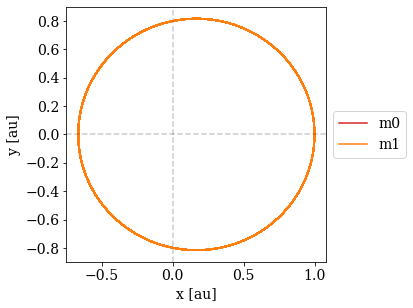

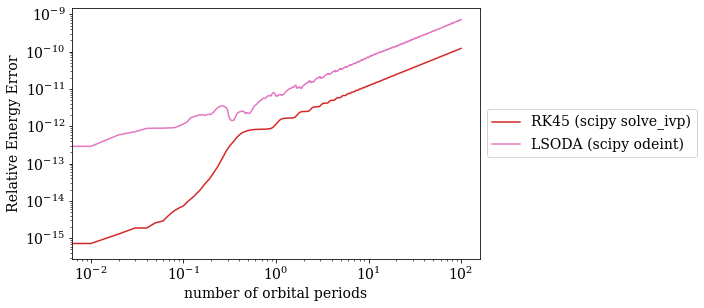

In [6]:
orbital_periods = np.arange(N_steps)/steps_per_orbit

plt.figure(figsize=(10,4.5))
plt.plot(orbit_soln[0,0], orbit_soln[0,1], label='m0', c='tab:red')
plt.plot(orbit_soln[1,0], orbit_soln[1,1], label='m1', c='tab:orange')
#plt.scatter(orbit_soln[2,0], orbit_soln[2,1], label='m2', c='tab:olive')

plt.axhline(0, ls='--', alpha=0.2, c='black')
plt.axvline(0, ls='--', alpha=0.2, c='black')
plt.axis('scaled')
#plt.xlim(-50,50)
#plt.ylim(-10,90)
plt.xlabel('x [au]')
plt.ylabel('y [au]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('SS.jpg', dpi=300)
plt.show()

plt.figure(figsize=(10,4.5))
plt.loglog(orbital_periods, energy_error_rk, label='RK45 (scipy solve_ivp)', c='tab:red')
#plt.plot(orbital_periods, energy_error[1], label='RK23', c='tab:orange')
#plt.plot(orbital_periods, energy_error[2], label='DOP853', c='tab:olive')
#plt.plot(orbital_periods, energy_error[3], label='Radau', c='tab:green')
#plt.plot(orbital_periods, energy_error[4], label='BDF', c='tab:blue')
#plt.plot(orbital_periods, energy_error[5], label='LSODA', c='tab:purple')
plt.loglog(orbital_periods, energy_error_odeint, label='LSODA (scipy odeint)', c='tab:pink')
#plt.yscale('log')
#plt.xlim(3e-1, 1e2)
#plt.ylim(1e-7, 1)
plt.xlabel('number of orbital periods')
plt.ylabel('Relative Energy Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('comparison_ode.jpg', dpi=300)
plt.show()
